In [1]:
from itertools import product
from math import ceil

import pandas as pd
import seaborn as sns

from dataclasses import dataclass
from timeit import timeit

from ModuleBfv import BFV, BfvConfig
from random import randint
from tqdm import tqdm

from operator import add, mul
from typing import Callable
from ModuleBfv import get_error
from Polynomial import RingPoly
import multiprocessing as mp

from itertools import chain
from matplotlib import pyplot as plt
from matplotlib import ticker

sns.set_palette("tab10")
sns.set_theme(style="ticks")

# Lattice

In [26]:
from manim import Scene, config, Axes # General Stuff

from manim import Dot, Arrow, MathTex # Objects
from manim import WHITE, BLACK, GRAY, GREEN, RED # Colors
from manim import RIGHT, LEFT, DOWN, UP
config["background_color"] = WHITE
import numpy as np

basis = np.asarray([
    [1,1.5],
    [1, 0]
])

points = []
for q in range(-10, 10, 1):
    for j in range(-10, 10, 1):
        points.append(np.asarray([q, j]))

lattice_points = [basis @ p for p in points]

class LatticeGrid(Scene):

    def construct(self):
        ax = Axes(x_range=[-7, 7, 1],
                  y_range=[-7, 7, 1],
                  x_length=15,
                  y_length=15,
                  axis_config={
                      "stroke_color": GRAY,
                      "tick_size": 0
                  },
                  tips=False)

        dots = [
            Dot(ax.coords_to_point(p[0], p[1]), color=BLACK, radius=0.08)
            for p in lattice_points
        ]

        b1 = Arrow(ax.coords_to_point(0, 0),
                   ax.coords_to_point(*basis @ np.asarray([1, 0])),
                   color=GREEN,
                   buff=0)
        b1_text = MathTex(r"b_1", color=GREEN).next_to(b1, UP)
        b2 = Arrow(ax.coords_to_point(0, 0),
                   ax.coords_to_point(*basis @ np.asarray([0, 1])),
                   color=RED,
                   buff=0)
        b2_text = MathTex(r"b_2", color=RED).next_to(b2, RIGHT)

        self.add(ax, *dots, b1, b2, b1_text, b2_text)




Manim Community v0.18.1

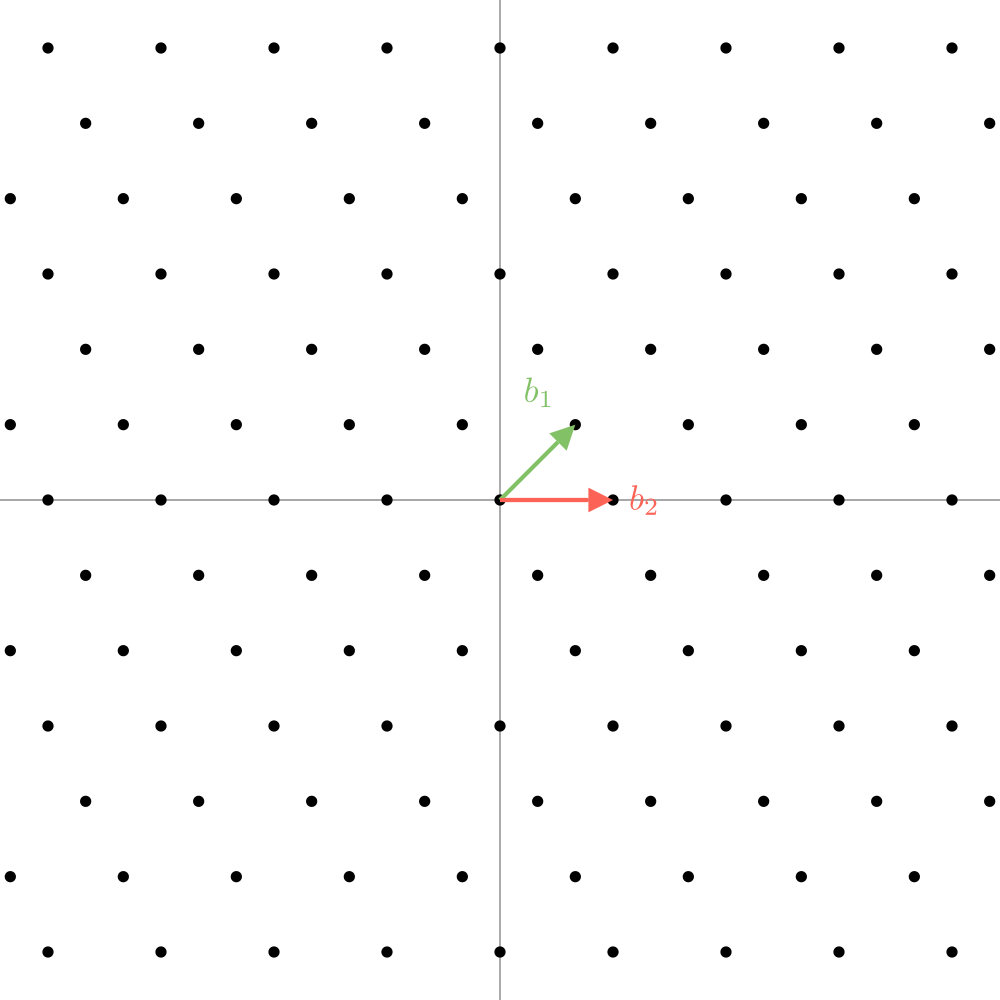

In [27]:
%manim -qm -v WARNING -r 1000,1000 LatticeGrid

# Output Size

In [2]:
def sk(n: int, d: int, **kwargs) -> int:
    return n * d

def pk(n: int, d: int, **kwargs) -> int:
    return (n*n+n) * d

def rlk(n: int, d: int, **kwargs) -> int:
    return n*((n*n+n) * d)

# def m(n: int, d: int, l:int, **kwargs) -> int:
#     return ceil(l/d) * d

def ct(n: int, d: int, **kwargs) -> int:
    return ((n+1) * d)


In [3]:
plwe = "Plain-LWE"
rlwe = "Ring-LWE"
mlwe = "Module-LWE"
schemes = [plwe, rlwe, mlwe]
functions = [sk, pk ,rlk, ct]
DataContainer = []

for function, scheme in product(functions, schemes):
    d_range = [1] if scheme == plwe else range(0, 257, 2)
    n_range = [1] if scheme == rlwe else range(0, 257, 2)
    for n in n_range:
        if n==0:
            n = 1
        for d in d_range:
            if d == 0:
                d= 1
            DataContainer.append({
                "scheme": scheme,
                "function": function.__name__,
                "n": n,
                "d": d,
                "bit": function(n=n, d=d)
            })
dn_df = pd.DataFrame(DataContainer)

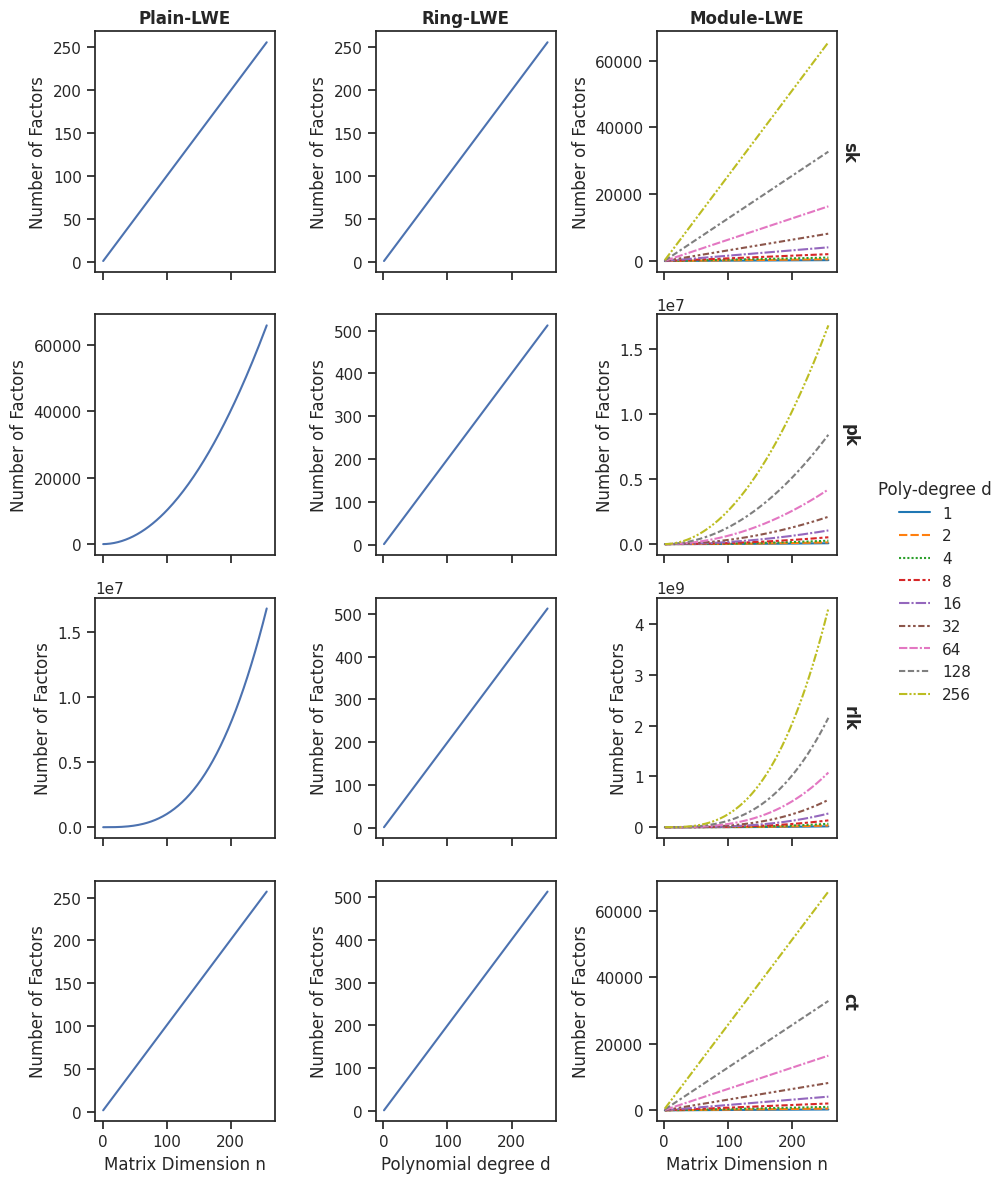

In [4]:
grid = sns.FacetGrid(dn_df, col="scheme", row="function",
                     margin_titles=True, despine=False, sharey=False, legend_out=True, sharex="col")
grid.set_titles(col_template="{col_name}",
                row_template="{row_name}", weight="bold")
grid.set_ylabels("number of factors")

vals = [2**i for i in range(9)]


def plot(data: pd.DataFrame, color, **kwargs):
    # print(kwargs)
    if data["scheme"].unique()[0] == rlwe:
        p = sns.lineplot(data, x="d", y="bit",
                         color=color)
        p.set_xlabel("Polynomial degree d")
    elif data["scheme"].unique()[0] == plwe:
        p = sns.lineplot(data, x="n", y="bit", color=color)
        p.set_xlabel(
            "Matrix Dimension n")
    else:
        data = data.loc[data.d.isin(vals)]
        p = sns.lineplot(data, x="n", y="bit", style="d", color=color, hue="d", palette="tab10",
                         legend="full")
        p.set_xlabel("Matrix Dimension n")
    p.set_ylabel("Number of Factors")


grid.map_dataframe(plot)
grid.add_legend(title='Poly-degree d')

# Performance Test

In [5]:
@dataclass
class DataContainer:
    method: str
    n: int
    d: int
    q: int
    p: int
    time: float


rounds = 10

def compute(x):
    n, d, q, p = x
    if n== 0:
        n = 1
    if d == 0:
        d= 1
    data = []
    conf = BfvConfig(n, d, 2**q, 2**(q*p))
    t_kg = timeit(lambda: BFV.keygen(conf), number=rounds) / rounds
    data.append(DataContainer("KeyGen", n, d, q, p, t_kg))

    sk, pk, rlk = BFV.keygen(conf)
    m = [randint(0, 1) for _ in range(0, d)]
    t_enc = timeit(lambda: BFV.encrypt(
        conf, pk, rlk, m), number=rounds) / rounds
    data.append(DataContainer("Encryption", n, d, q, p, t_enc))

    ct = BFV.encrypt(conf, pk, rlk, m)
    t_dec = timeit(lambda: BFV.decrypt(sk, ct), number=rounds) / rounds
    data.append(DataContainer("Decrypt", n, d, q, p, t_dec))

    t_add = timeit(lambda: ct+ct, number=rounds) / rounds
    data.append(DataContainer("Addition", n, d, q, p, t_add))

    t_mul = timeit(lambda: ct*ct, number=rounds) / rounds
    data.append(DataContainer("Multiplication", n, d, q, p, t_mul))

    return data

# parameters = list(product(range(0, 33, 2), range(0, 33, 2), [32], [3]))*4
# with mp.Pool(mp.cpu_count()) as pool:
#     dn_res = list(tqdm(pool.imap_unordered(compute, reversed(parameters)), total=len(parameters)))

# parameters = list(product([10], [10], range(4, 81, 4), range(1, 11)))*20
# with mp.Pool(mp.cpu_count()) as pool:
#     qp_res = list(tqdm(pool.imap_unordered(compute, reversed(parameters)), total=len(parameters)))

parameters = ([1, 512, 15, 3], [3, 256, 13, 3])*20
with mp.Pool(mp.cpu_count()) as pool:
    alg_res = list(tqdm(pool.imap_unordered(compute, reversed(parameters)), total=len(parameters)))

100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


In [9]:
# dn_df = pd.DataFrame(chain(*dn_res))
# dn_df.to_csv("dn_performance.csv")
# qp_df = pd.DataFrame(chain(*qp_res))
# qp_df.to_csv("qp_performance.csv")
alg_df = pd.DataFrame(chain(*alg_res))

dn_df = pd.read_csv("data/dn_performance.csv")
qp_df = pd.read_csv("data/qp_performance.csv")

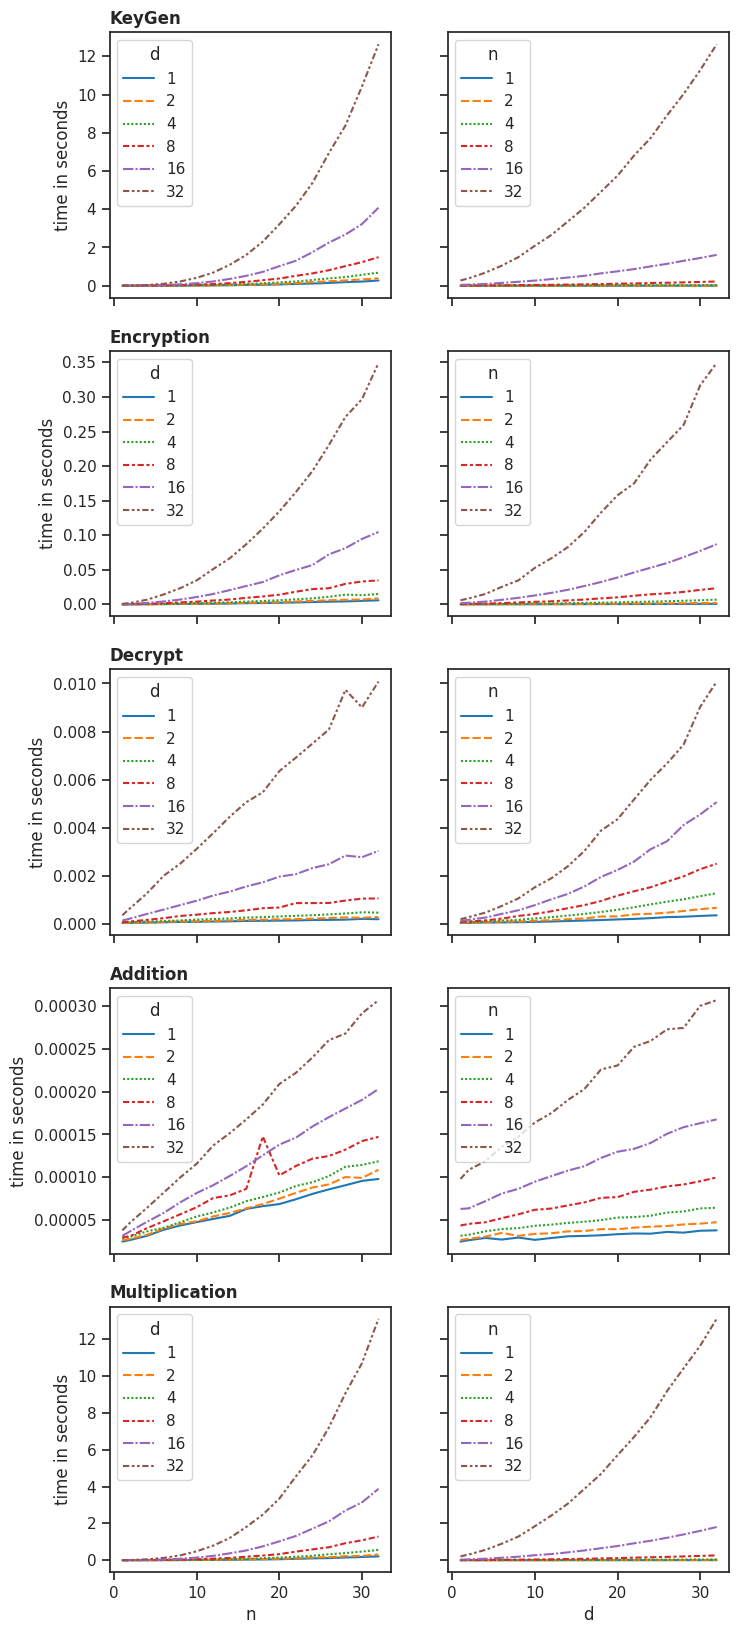

In [10]:
sns.set_theme(style="ticks")
rows = dn_df["method"].unique()
fig, axs = plt.subplots(ncols=2, nrows=len(rows), figsize=(8,4*len(rows)), sharex="all", sharey="row")
vals = [2**i for i in range(7)]
for row, method in zip(axs, rows):
    sub_df = dn_df.loc[dn_df["method"] == method].drop(columns=["method"]).groupby(["n", "d", "p", "q"]).median().reset_index()
    row[0].set_title(method, loc="left", weight="bold")
    left = sns.lineplot(sub_df.loc[sub_df.d.isin(vals)], x="n", y="time", ax=row[0], style="d", hue="d", palette="tab10")
    left.set_ylabel("time in seconds")
    sns.lineplot(sub_df.loc[sub_df.n.isin(vals)], x="d", y="time", ax=row[1], style="n", hue="n", palette="tab10")

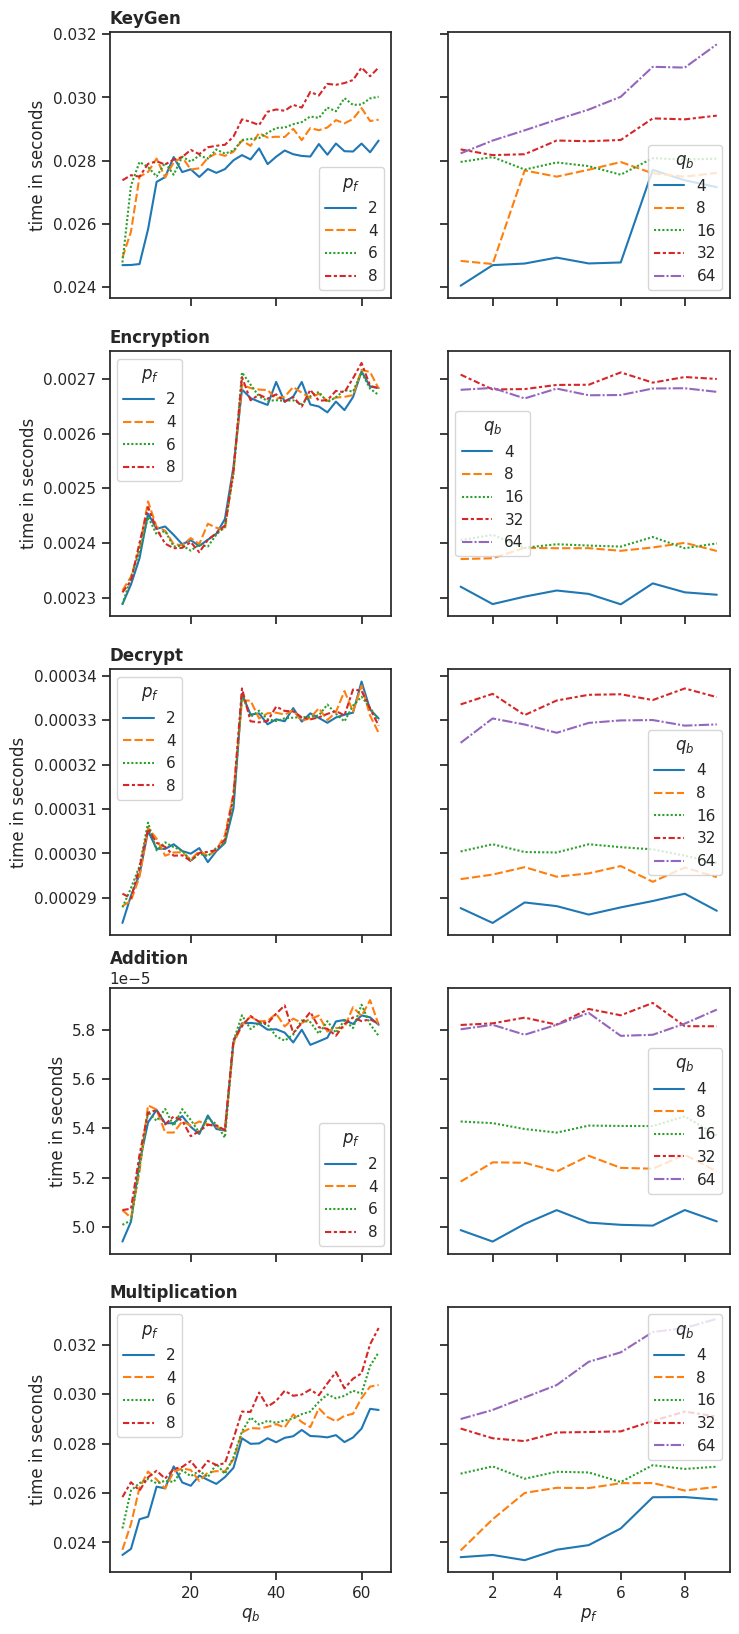

In [11]:
sns.set_theme(style="ticks")
rows = qp_df["method"].unique()
fig, axs = plt.subplots(ncols=2, nrows=len(rows), figsize=(8,4*len(rows)), sharex="col", sharey="row")
vals = [2**i for i in range(7)]
for row, method in zip(axs, rows):
    sub_df = qp_df.loc[qp_df["method"] == method].drop(columns=["method"]).groupby(["n", "d", "p", "q"]).median().reset_index()
    row[0].set_title(method, loc="left", weight="bold")
    left = sns.lineplot(sub_df.loc[sub_df.p.isin([i*2 for i in range(7)])], x="q", y="time", ax=row[0], style="p", hue="p", palette="tab10")
    left.legend(title="$p_f$")
    left.set_xlabel("$q_b$")
    left.set_ylabel("time in seconds")
    left.set_ylabel("time in seconds")
    right = sns.lineplot(sub_df.loc[sub_df.q.isin([2**i for i in range(7)])], x="p", y="time", ax=row[1], style="q", hue="q", palette="tab10")
    right.legend(title="$q_b$")
    right.set_xlabel("$p_f$")

In [12]:
print(alg_df.groupby(["method", "n", "d", "p", "q"])
        .median()
        .reset_index()
        .assign(algorithm=lambda x: x.n.mask(lambda x: x==1, "R-LWE")
                                        .mask(lambda x: x==3, "M-LWE"))
        .sort_values("algorithm")
        .pivot_table(columns="method", aggfunc="first", index="algorithm", values="time")
        .to_latex()
) # yapf: disable


\begin{tabular}{lrrrrr}
\toprule
method & Addition & Decrypt & Encryption & KeyGen & Multiplication \\
algorithm &  &  &  &  &  \\
\midrule
M-LWE & 0.000168 & 0.038820 & 0.158649 & 0.687160 & 0.822141 \\
R-LWE & 0.000160 & 0.056822 & 0.114975 & 0.173960 & 0.384920 \\
\bottomrule
\end{tabular}



# Multiplicative and Additive Depth

In [13]:
@dataclass
class DataContainer:
    method: str
    n: int
    d: int
    q: int
    p: int
    depth: int
    error: float
    is_wrong: bool


def get_depth(operation: Callable, x, max_rounds=100):
    n, d, q, p = x
    d = 2**d
    conf = BfvConfig(n, d, 2**q, 2**(q*p))
    sk, pk, rlks = BFV.keygen(conf)
    m1 = RingPoly.random_ring_poly(conf.poly_len, 0, 1)
    m_e1 = BFV.encrypt(conf, pk, rlks, m1)
    data = []
    for i in range(max_rounds):
        m2 = RingPoly.random_ring_poly(conf.poly_len, 0, 1)
        m_e2 = BFV.encrypt(conf, pk, rlks, m2)
        m_e1 = operation(m_e1, m_e2)
        m1 = operation(m1, m2) % 2

        # m_e1 = operation(m_e1, m_e1)
        # m1 = operation(m1, m1) % 2

        if BFV.decrypt(sk, m_e1) != m1:
            break
        data.append(DataContainer(operation.__name__,
                    n, d, q, p, i, get_error(m_e1, m1, sk), False))
    
    last_error = get_error(m_e1, m1, sk)
    data += [DataContainer(operation.__name__, n, d, q, p, i, last_error, True)
             for i in range(i, max_rounds)]
    return data


def compute_mul(x):
    return get_depth(mul, x, 100)


def compute_add(x):
    return get_depth(add, x, 200)


## Multiplication ###
parameters = list(product(range(1, 6), range(0, 6),
                  range(20, 81, 20), range(1, 15, 1))) * 30
with mp.Pool(mp.cpu_count()) as pool:
    mul_res = list(tqdm(pool.imap_unordered(
        compute_mul, reversed(parameters)), total=len(parameters)))


### Addition ##
parameters = list(product(range(1, 6), range(0, 6),
                  range(4, 36, 4), [5])) * 20
with mp.Pool(mp.cpu_count()) as pool:
    add_res = list(tqdm(pool.imap_unordered(
        compute_add, reversed(parameters)), total=len(parameters)))

### Algorithm ###
alg_res = []
parameters = (list(product([1], [9], [15, 20, 32, 64, 128], [3])) +list(product([3], [8], [13, 20, 32, 64, 128], [3])))*10
with mp.Pool(mp.cpu_count()) as pool:
    alg_res += list(tqdm(pool.imap_unordered(
        compute_mul, reversed(parameters)), total=len(parameters)))
    alg_res += list(tqdm(pool.imap_unordered(
        compute_add, reversed(parameters)), total=len(parameters)))

  1%|          | 291/50400 [00:04<14:15, 58.59it/s] 


KeyboardInterrupt: 

In [14]:
# mul_df = pd.DataFrame(chain(*mul_res))
# add_df = pd.DataFrame(chain(*add_res))
# alg_df = pd.DataFrame(chain(*alg_res))

# mul_df.to_csv("mul_depth_data.csv")
# add_df.to_csv("add_depth_data.csv")
# alg_df.to_csv("alg_depth_data.csv")

mul_df = pd.read_csv("data/mul_depth_data.csv", index_col=0)
add_df = pd.read_csv("data/add_depth_data.csv", index_col=0)
alg_df = pd.read_csv("data/alg_depth_data.csv", index_col=0)

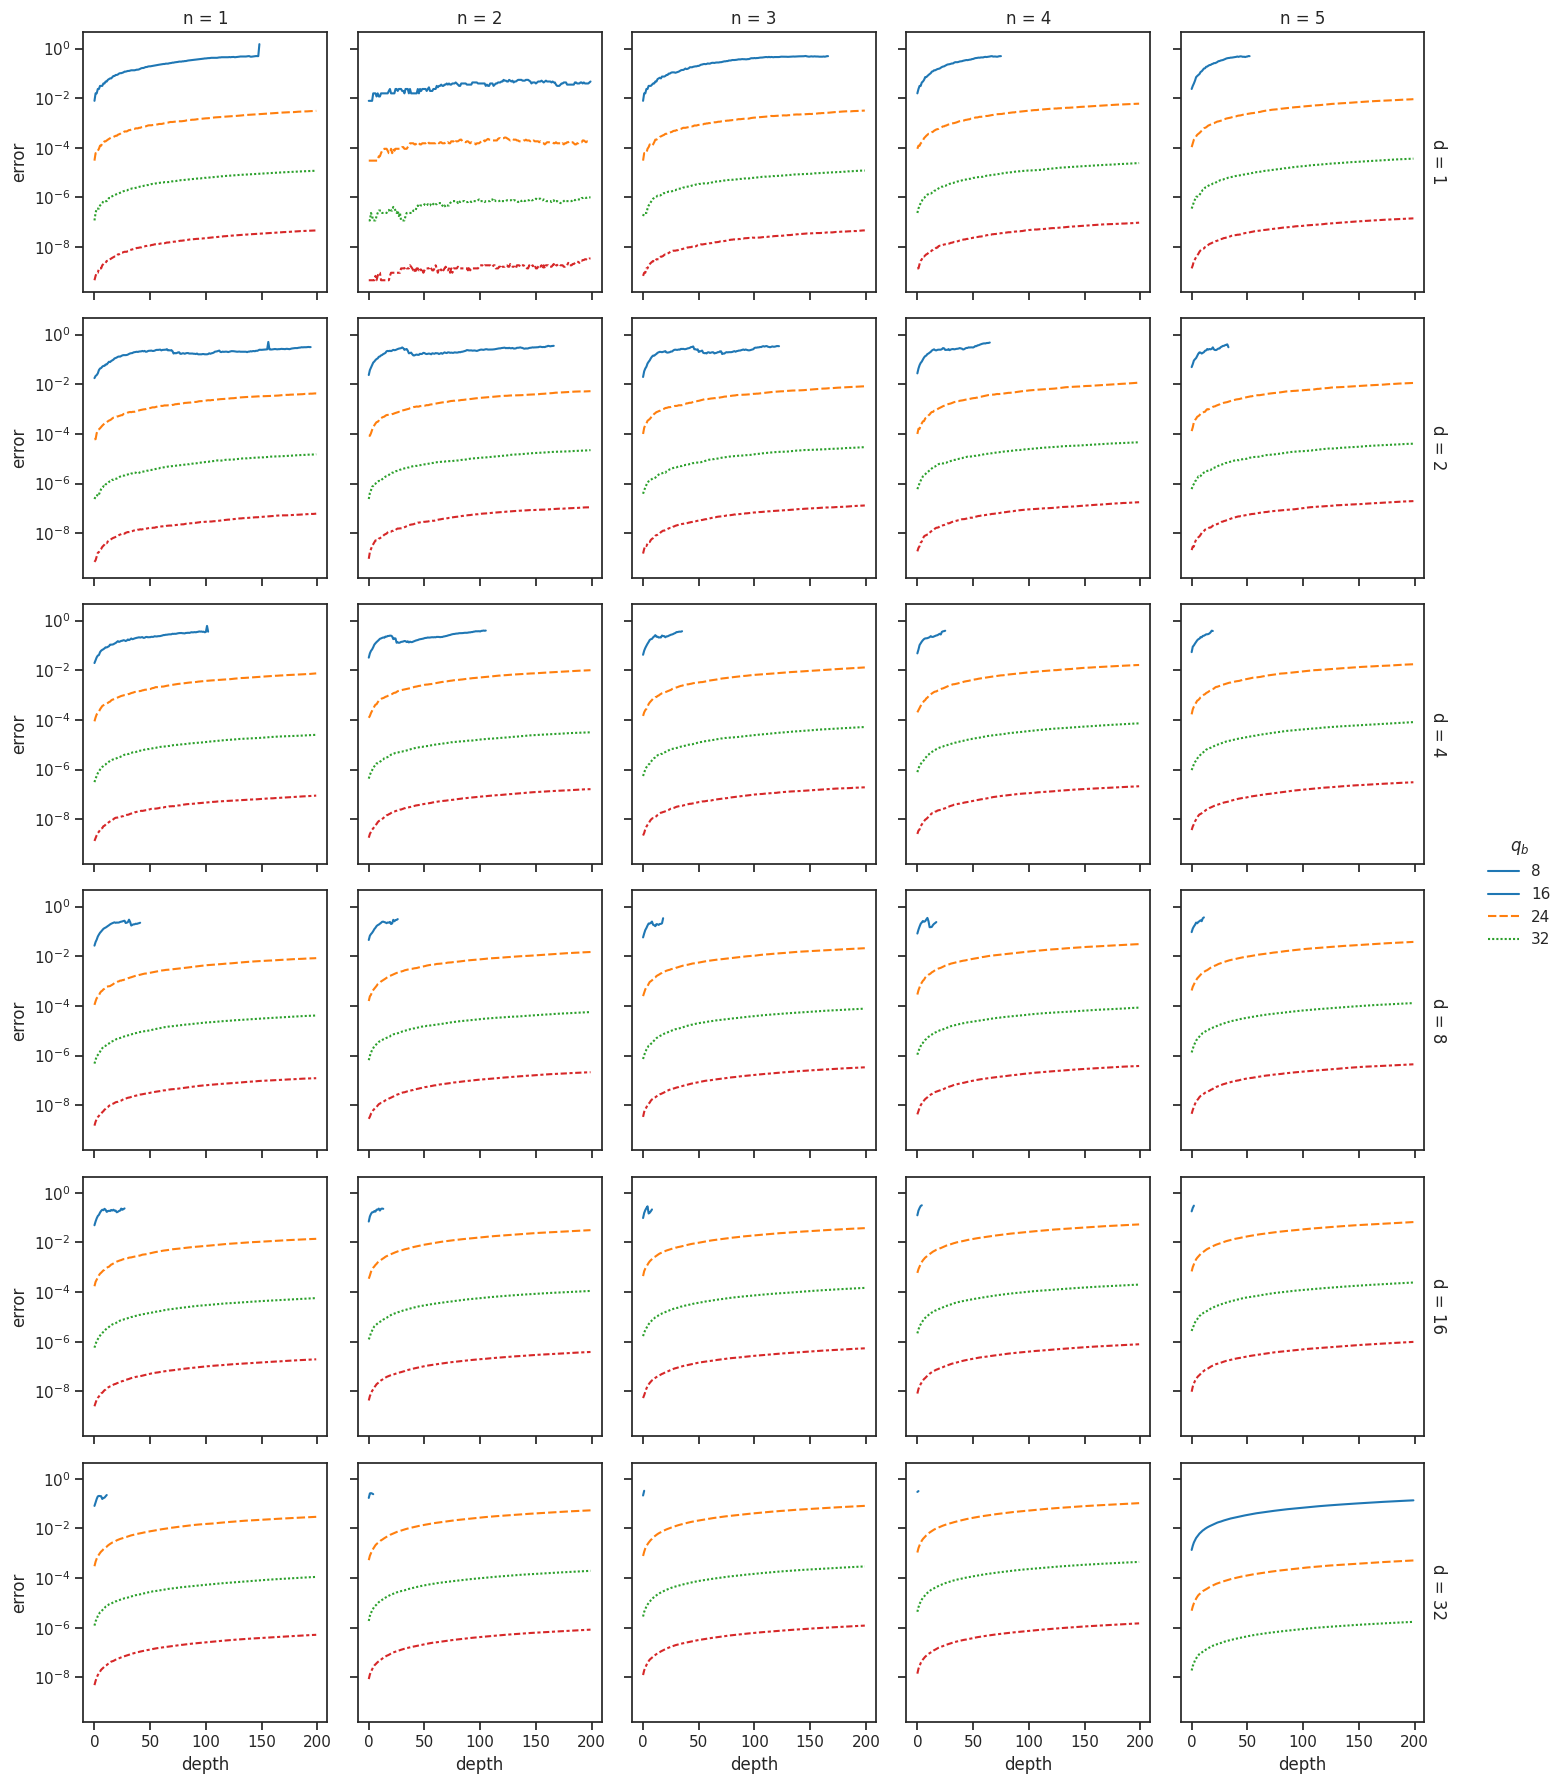

In [15]:
grid = sns.FacetGrid(
    add_df.drop(columns=["method"])
    .groupby(["n", "d", "q", "depth", "p"]).filter(lambda x: any(~x["is_wrong"]))
    .drop(columns="is_wrong").groupby(["n", "d", "q", "depth", "p"]).median().reset_index(),
    col="n", row="d", margin_titles=True,
    despine=False, sharey=True, legend_out=True, sharex="all")


def plot(data: pd.DataFrame, color):
    p = sns.lineplot(data.loc[data.q % 8 == 0], x="depth", y="error", legend="full", estimator="median", style="q", hue="q", palette="tab10")
    p.set(yscale="log")


grid.map_dataframe(plot)
grid.add_legend(title='$q_b$')

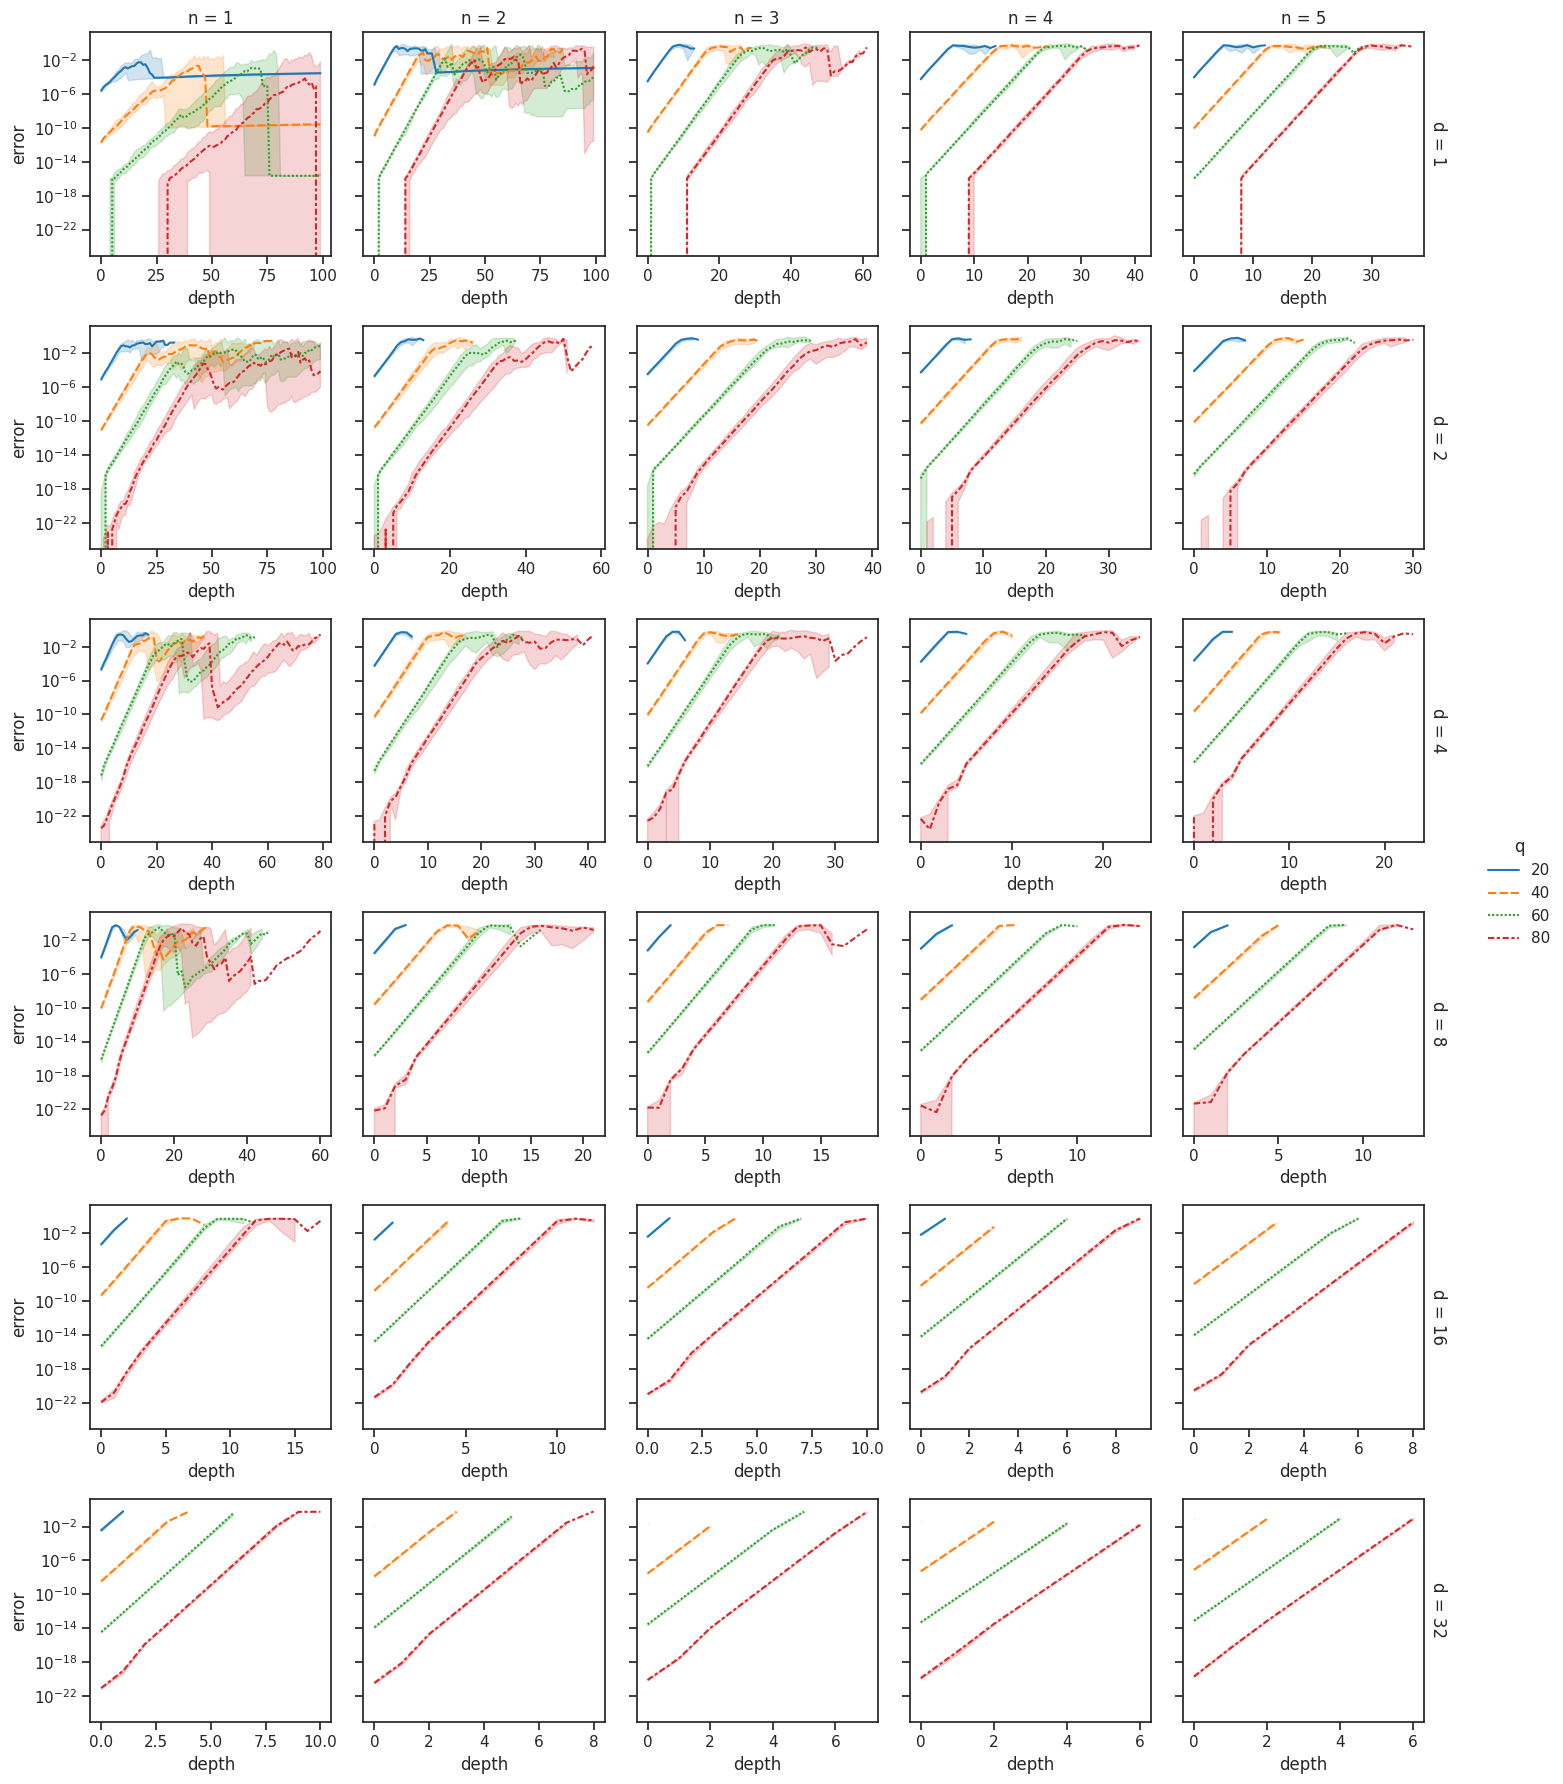

In [16]:
grid = sns.FacetGrid(
    mul_df.drop(columns=["method"])
    .groupby(["n", "d", "q", "depth", "p"]).filter(lambda x: any(~x["is_wrong"]))
    .drop(columns="is_wrong").groupby(["n", "d", "q", "depth", "p"]).median().reset_index(),
    col="n", row="d", margin_titles=True,
    despine=False, sharey=True, legend_out=True, sharex=False)


def plot(data: pd.DataFrame, color):
    p = sns.lineplot(data, x="depth", y="error",
                     legend="full", estimator="median", errorbar=lambda x: (x.min(), x.max()), style="q", hue="q", palette="tab10")
    p.set(yscale="log")
    p.legend(title="q_b")


grid.map_dataframe(plot)
grid.add_legend(title='q')

In [17]:
print(alg_df
    .groupby(["method","n", "d", "q", "p", "depth", "is_wrong"])
    .median()
    .reset_index()
    .loc[lambda x: x["is_wrong"]]
    .groupby(["method","n", "d", "q", "p"])
    .apply(lambda x:  x.sort_values("depth").drop_duplicates(subset=["is_wrong"], keep="first"))
    .reset_index(drop=True)
    .assign(algorithm=lambda x: x.n.mask(lambda x: x==1, "R-LWE")
                                    .mask(lambda x: x==3, "M-LWE"))
    .drop(columns=["error", "is_wrong", "p", "n", "d"])
    .sort_values(["algorithm", "method", "q"])
    .pivot_table(columns=["method", "q"], aggfunc="first", index="algorithm", values="depth")
    .round()
    .apply(lambda x: pd.to_numeric(x, downcast="integer"))
    .to_latex()
) # yapf: disable

\begin{tabular}{lrrrr}
\toprule
method & \multicolumn{2}{r}{add} & \multicolumn{2}{r}{mul} \\
q & 13 & 15 & 13 & 15 \\
algorithm &  &  &  &  \\
\midrule
M-LWE & 8.000000 & NaN & 0.000000 & NaN \\
R-LWE & NaN & 51.000000 & NaN & 0.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_17056/3906227303.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x:  x.sort_values("depth").drop_duplicates(subset=["is_wrong"], keep="first"))
